<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/Probabilistic_deep_learning_TensorFlow2/Probabilistic_layers_Bayesian_neural_networks/Bayesian_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

import numpy as np
np.random.seed(42)
import pandas as pd

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)
# Setting fixed random seed to have reproducibility
tf.random.set_seed(42)

TF version: 2.8.0
TFP version: 0.16.0


In [3]:
class PlotMetrics():
    plt_nrows = 1
    plt_ncols = 2
    plt_figsize = (15, 5)

    def __init__(self, history=None, metrics=['loss', None]):
        super().__init__()
        self.history = history
        self.metrics = metrics

    @classmethod
    def _create_plot(cls):
        return plt.subplots(nrows=cls.plt_nrows,
            ncols=cls.plt_ncols, figsize=cls.plt_figsize)

    def plot(self):
        df = pd.DataFrame(self.history.history)
        x = np.arange(1, len(df)+1)
        fig, axs = self._create_plot()

        for metric, ax in zip(self.metrics, axs):
            y11 = df[metric]
            ax.plot(x, y11, label='Training')
            y12 = df['val_' + metric]
            ax.plot(x, y12, label='Validation')
            ax.set_xlabel('Epoch')
            ax.set_ylabel(metric)
            ax.set_title(metric + " vs Epoch")
            ax.legend()
        plt.show()

In [4]:
class GetParams():

    def __init__(self, model=None, layer=None):
        super().__init__()
        self.model = model
        self.layer = layer

    def get(self):
        return self.model.get_layer(self.layer).get_weights()

# Probabilistic layers and Bayesian neural networks

## Coding tutorials
#### [1. The DistributionLambda layer](#coding_tutorial_1)
#### [2. Probabilistic layers](#coding_tutorial_2)
#### [3. The DenseVariational layer](#coding_tutorial_3)
#### [4. Reparameterization layers](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## The `DistributionLambda` layer

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanAbsoluteError
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

inputs = Input(shape=(2, ), name='Input01')
h = Dense(1, name='FC01')(inputs)
outputs = tfpl.DistributionLambda(
    lambda t: tfd.Normal(loc=t, scale=1), name='Output01')(h)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input01 (InputLayer)        [(None, 2)]               0         
                                                                 
 FC01 (Dense)                (None, 1)                 3         
                                                                 
 Output01 (DistributionLambd  ((None, 1),              0         
 a)                           (None, 1))                         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input01 (InputLayer)        [(None, 2)]               0         
                                                                 
 FC01 (Dense)                (None, 1)                 3         
                                                                 
 Output01 (DistributionLambd  ((None, 1),              0         
 a)                           (None, 1))                         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


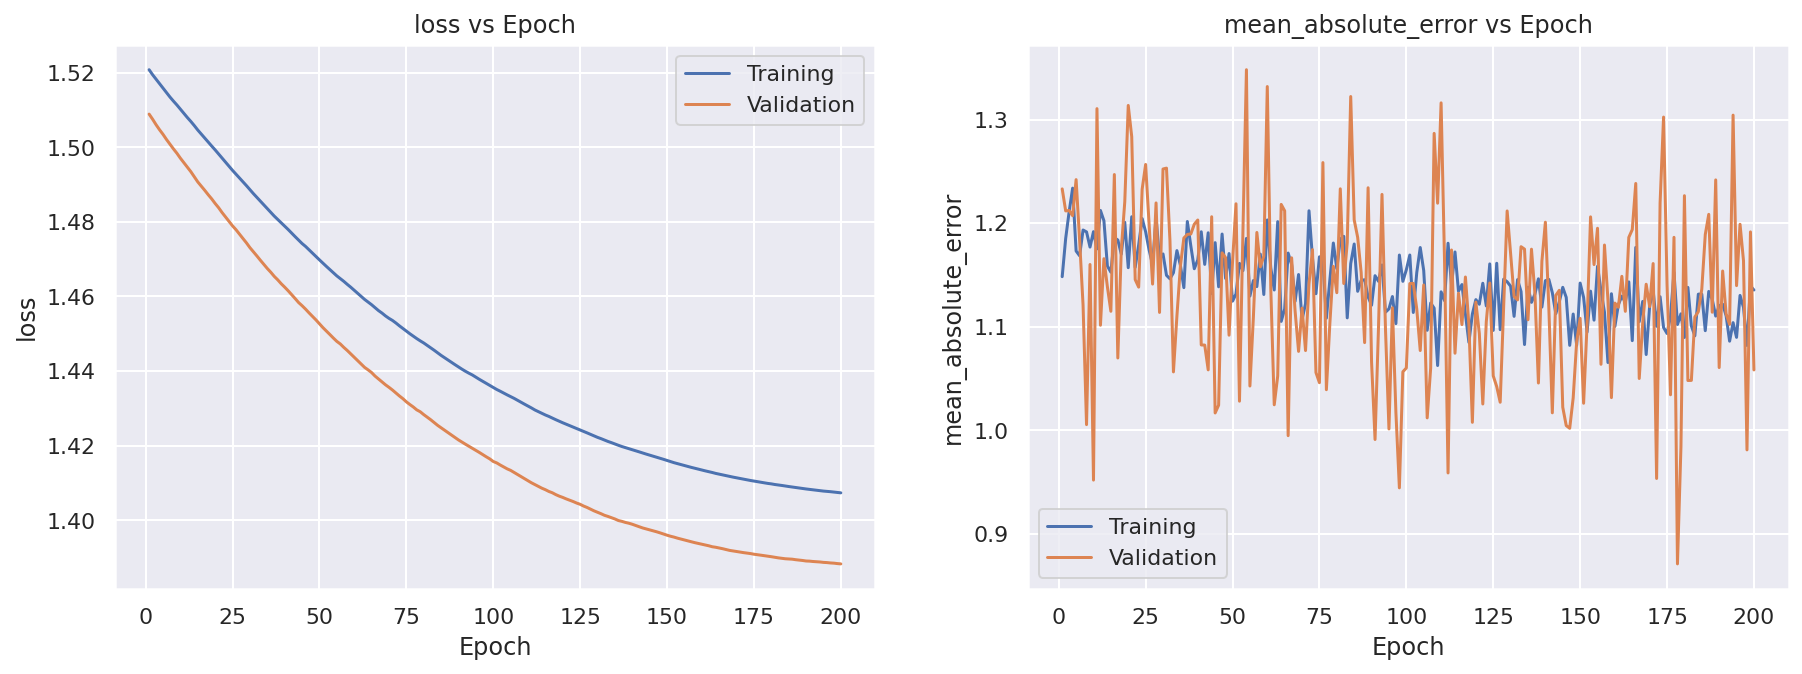

Test loss: 1.5497
Test mean absolute error: 1.3446
Sample:  tf.Tensor(
[[ 0.42612958]
 [-0.46663916]
 [ 0.39639705]
 [-0.9576257 ]
 [ 0.8212302 ]], shape=(5, 1), dtype=float32)
Mean:  tf.Tensor(
[[-0.23035719]
 [-0.05358748]
 [ 0.05642198]
 [ 0.04800145]
 [ 0.11856781]], shape=(5, 1), dtype=float32)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanAbsoluteError
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

inputs = Input(shape=(2,), name='Input01')
h = Dense(1, name='FC01')(inputs)
outputs = tfpl.DistributionLambda(
    lambda t: tfd.Normal(loc=t, scale=1), 
    convert_to_tensor_fn=tfd.Distribution.sample,
    name='Output01')(h)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, 
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=[MeanAbsoluteError()])

x_train = np.random.normal(size=(1000, 2))
y_train = np.random.normal(size=(1000,))
history = model.fit(x_train, y_train, validation_split=0.1,
    epochs=200, batch_size=32, verbose=0)

fig = PlotMetrics(history=history,
    metrics=['loss', 'mean_absolute_error'])
fig.plot()

x_test = np.random.normal(size=(5, 2))
y_test = np.random.normal(size=(5,))
test_loss, test_mae = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}\n"
    f"Test mean absolute error: {test_mae:.4f}")
print("Sample: ", model(x_test).sample())
print("Mean: ", model(x_test).mean())

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

inputs = Input(shape=(12, ), name='Input01')
h = Dense(8, name='FC01')(inputs)
outputs = tfpl.DistributionLambda(
    lambda t: tfd.Bernoulli(logits=t))(h)
model = Model(inputs=inputs, outputs=outputs)
model.summary()
model(np.ones((3, 12))).sample(2)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input01 (InputLayer)        [(None, 12)]              0         
                                                                 
 FC01 (Dense)                (None, 8)                 104       
                                                                 
 distribution_lambda (Distri  ((None, 8),              0         
 butionLambda)                (None, 8))                         
                                                                 
Total params: 104
Trainable params: 104
Non-trainable params: 0
_________________________________________________________________


<tf.Tensor: shape=(2, 3, 8), dtype=int32, numpy=
array([[[1, 0, 0, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 0, 1, 1, 0]],

       [[1, 1, 1, 1, 1, 0, 0, 1],
        [1, 1, 1, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 0, 1, 0, 0]]], dtype=int32)>

#### Create a probabilistic model using the `DistributionLambda` layer

Create a model whose first layer represents:

$$
y = \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input01 (InputLayer)        [(None, 1)]               0         
                                                                 
 FC01 (Dense)                (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


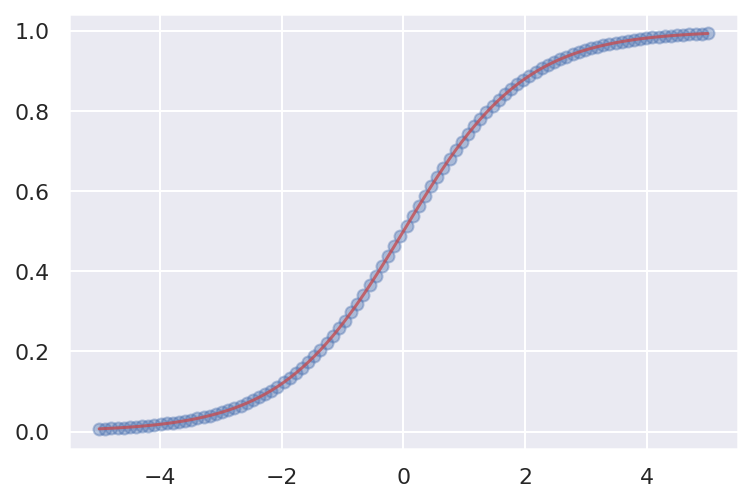

x: [[0]]
y_model: [[0.5]]
predict: [[0.5]]
predict: [[0.5]]
predict: [[0.5]]


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Create a sigmoid model, first deterministic, then probabilistic

inputs = Input(name='Input01', shape=(1,))
outputs = Dense(name='FC01', units=1, activation='sigmoid',
    kernel_initializer=tf.constant_initializer(1),
    bias_initializer=tf.constant_initializer(0))(inputs)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color='r', alpha=0.8)
plt.show()

# Create a constant input for this model
x = np.array([[0]])
print(f"x: {x}")

# Explore the feedforward object...
y_model = model(x)
print(f"y_model: {y_model}")

# ... and its behaviour under repeated calls
for _ in range(3):
    print(f"predict: {model.predict(x)}")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input01 (InputLayer)        [(None, 1)]               0         
                                                                 
 FC01 (Dense)                (None, 1)                 2         
                                                                 
 distribution_lambda_1 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


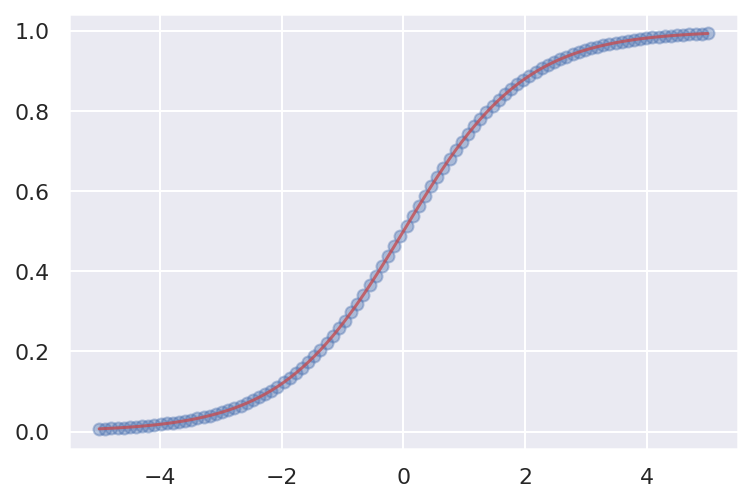

x: [[0]]
y_model: tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1, 1], event_shape=[], dtype=int32)
predict: [[0.5]]
predict: [[0.5]]
predict: [[0.5]]


In [9]:
# Create a sigmoid model, first deterministic, then probabilistic
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

inputs = Input(name='Input01', shape=(1,))
h = Dense(name='FC01', units=1, activation='sigmoid',
    kernel_initializer=tf.constant_initializer(1),
    bias_initializer=tf.constant_initializer(0))(inputs)
outputs = tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
    convert_to_tensor_fn=tfd.Distribution.mean)(h)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color='r', alpha=0.8)
plt.show()

# Create a constant input for this model
x = np.array([[0]])
print(f"x: {x}")

# Explore the feedforward object...
y_model = model(x)
print(f"y_model: {y_model}")

# ... and its behaviour under repeated calls
for _ in range(3):
    print(f"predict: {model.predict(x)}")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input01 (InputLayer)        [(None, 1)]               0         
                                                                 
 FC01 (Dense)                (None, 1)                 2         
                                                                 
 distribution_lambda_2 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


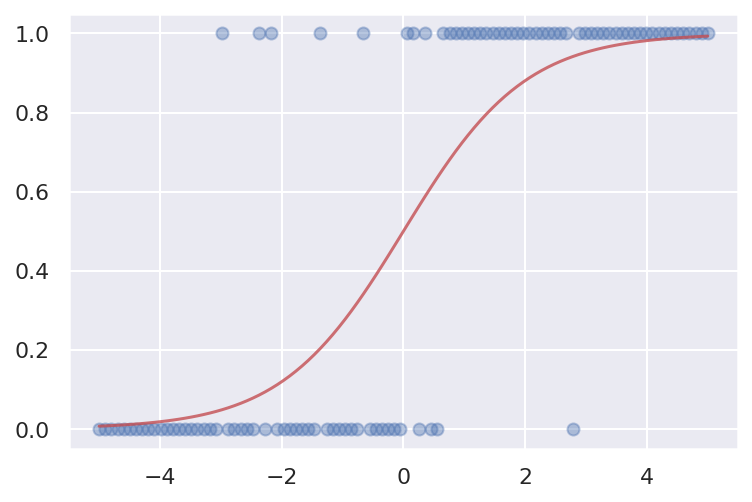

x: [[0]]
y_model: tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1, 1], event_shape=[], dtype=int32)
predict: [[0]]
predict: [[0]]
predict: [[1]]


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

# Create a sigmoid model, first deterministic, then probabilistic

inputs = Input(name='Input01', shape=(1,))
h = Dense(name='FC01', units=1, activation='sigmoid',
    kernel_initializer=tf.constant_initializer(1),
    bias_initializer=tf.constant_initializer(0))(inputs)
outputs = tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
    convert_to_tensor_fn=tfd.Distribution.sample)(h)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color='r', alpha=0.8)
plt.show()

# Create a constant input for this model
x = np.array([[0]])
print(f"x: {x}")

# Explore the feedforward object...
y_model = model(x)
print(f"y_model: {y_model}")

# ... and its behaviour under repeated calls
for _ in range(3):
    print(f"predict: {model.predict(x)}")

#### Use the forward model to create probabilistic training data

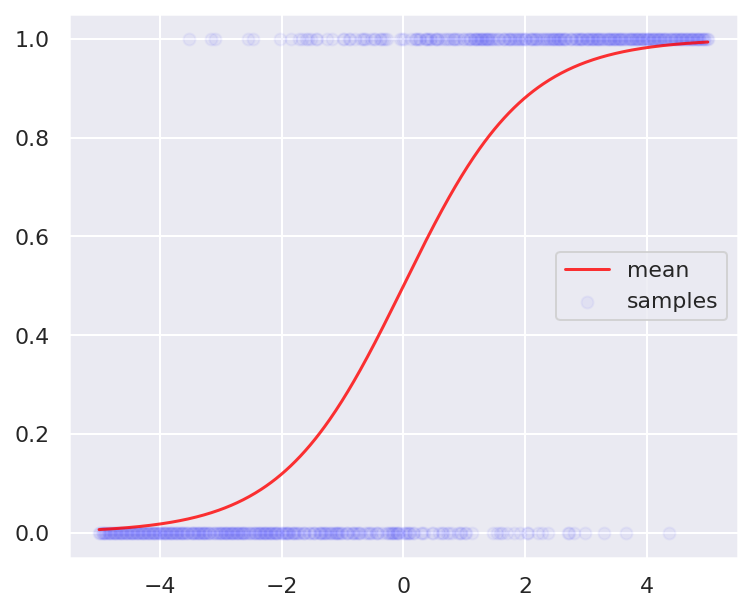

In [13]:
# Use the model to create 500 training points
x_train = np.linspace(-5, 5, 500)[:, np.newaxis]
y_train = model.predict(x_train)

# Plot the data and the mean of the distribution
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(x_train, y_train, alpha=0.04, color='blue', label='samples')
ax.plot(x_train, model(x_train).mean().numpy().flatten(), 
    color='red', alpha=0.8, label='mean')
ax.legend()
plt.show()

#### Create a new probabilistic model with the wrong weights

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

# Create a new version of the model, with the wrong weights
inputs = Input(name='Input01', shape=(1,))
h = Dense(name='FC01', units=1, activation='sigmoid',
    kernel_initializer=tf.constant_initializer(2),
    bias_initializer=tf.constant_initializer(2))(inputs)
outputs = tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
    convert_to_tensor_fn=tfd.Distribution.sample)(h)
model_untrained = Model(inputs=inputs, outputs=outputs)
model_untrained.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input01 (InputLayer)        [(None, 1)]               0         
                                                                 
 FC01 (Dense)                (None, 1)                 2         
                                                                 
 distribution_lambda_6 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


#### Train the new model with the negative loglikelihood

In [42]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Accuracy

# Define negative loglikelihood, which we will use for training
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

# Compile untrained model
model_untrained.compile(loss=nll, 
    optimizer=RMSprop(learning_rate=1e-3),
    metrics=[Accuracy()])

In [46]:
# Train model, record weights after each epoch

epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0, 0]]
training_bias = [model_untrained.weights[1].numpy()[0]]
history = []
for epoch in range(100):
    train_history = model_untrained.fit(x=x_train, y=y_train, validation_split=0.1,
        epochs=1, batch_size=32, verbose=0)
    history.append(train_history)
    epochs.append(epoch)
    training_weights.append(model_untrained.weights[0].numpy()[0, 0])
    training_bias.append(model_untrained.weights[1].numpy()[0])

train_loss, train_accuracy = model_untrained.evaluate(
    x_train, y_train, verbose=0)
print(f"Train loss: {train_loss:.4f}\n"
    f"Train accuracy: {train_accuracy:.4f}")

Train loss: 0.3616
Train accuracy: 0.7620


In [ ]:
for t in range(len(history)):
  fig = PlotMetrics(history=history[t], metrics=['loss', 'accuracy'])
  fig.plot()

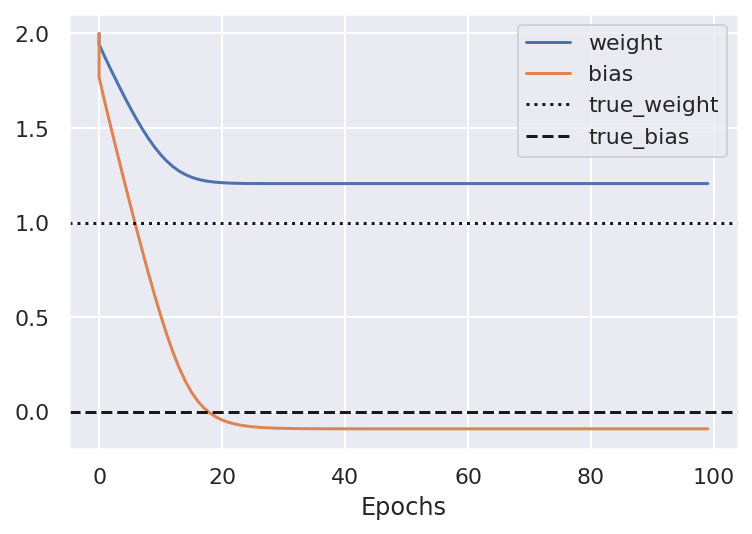

In [ ]:
# Plot the model weights as they train, converging to the correct values

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='k', linestyle=':')
plt.axhline(y=0, label='true_bias', color='k', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show()

***
<a id="coding_tutorial_2"></a>
## Probabilistic layers

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(2), # (batch_size, 2)
    tfpl.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(loc=t[..., :1], 
        scale=tf.math.softplus(t[..., 1:])),
        reinterpreted_batch_ndims=None))
])
model.summary()
# x_sample: (16, 2)
x_sample = np.random.uniform(size=(16, 2))

model(x_sample)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 16)                48        
                                                                 
 dense_34 (Dense)            (None, 2)                 34        
                                                                 
 distribution_lambda_20 (Dis  ((None, 1),              0         
 tributionLambda)             (None, 1))                         
                                                                 
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[16] event_shape=[1] dtype=float32>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(16, activation='relu', input_shape=(2, )),
    Dense(2), # (1 for mean, 1 for std)
    tfpl.IndependentNormal(1) # event_shape (1)
])
model.summary()

# x_sample: (16, 2)
x_sample = np.random.uniform(size=(16, 2))

model(x_sample)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 16)                48        
                                                                 
 dense_36 (Dense)            (None, 2)                 34        
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                                 
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[16] event_shape=[1] dtype=float32>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(4), # (2 for mean, 2 for std)
    tfpl.IndependentNormal(2) # event_shape (2)
])
model.summary()

# x_sample (16, 2)
x_sample = np.random.normal(size=(16, 2))

model(x_sample)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 16)                48        
                                                                 
 dense_38 (Dense)            (None, 4)                 68        
                                                                 
 independent_normal_1 (Indep  ((None, 2),              0         
 endentNormal)                (None, 2))                         
                                                                 
Total params: 116
Trainable params: 116
Non-trainable params: 0
_________________________________________________________________


<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[16] event_shape=[2] dtype=float32>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(8), # ((2, 2) for mean, (2, 2) for std)
    tfpl.IndependentNormal((2, 2)) # event_shape (2, 2)
])
model.summary()

# x_sample: (16, 2)
x_sample = np.random.normal(size=(16, 2))
model(x_sample)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 16)                48        
                                                                 
 dense_40 (Dense)            (None, 8)                 136       
                                                                 
 independent_normal_2 (Indep  ((None, 2, 2),           0         
 endentNormal)                (None, 2, 2))                      
                                                                 
Total params: 184
Trainable params: 184
Non-trainable params: 0
_________________________________________________________________


<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[16] event_shape=[2, 2] dtype=float32>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

event_shape = (2, 2)

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(tfpl.IndependentNormal.params_size(event_shape)),
    tfpl.IndependentNormal(event_shape, 
        convert_to_tensor_fn=tfd.Distribution.sample)
])
model.summary()

# x_sample: (16, 2)
x_sample = np.random.normal(size=(16, 2))
model(x_sample)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                48        
                                                                 
 dense_42 (Dense)            (None, 8)                 136       
                                                                 
 independent_normal_3 (Indep  ((None, 2, 2),           0         
 endentNormal)                (None, 2, 2))                      
                                                                 
Total params: 184
Trainable params: 184
Non-trainable params: 0
_________________________________________________________________


<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[16] event_shape=[2, 2] dtype=float32>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

from sklearn.preprocessing import LabelBinarizer

num_classes = 10

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(tfpl.OneHotCategorical.params_size(num_classes)),
    tfpl.OneHotCategorical(num_classes)
])
model.summary()
model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true))

x_train = np.random.normal(size=(1000, 32, 32, 3))
y_train = np.random.randint(size=(1000,), low=0, high=10)
y_train = LabelBinarizer().fit_transform(y_train)
model.fit(x_train, y_train, epochs=20, verbose=False)
print(f"loss: {model.evaluate(x_train, y_train)}")

# x_test: (1, 32, 32, 3)
x_test = np.random.normal(size=(1, 32, 32, 3))
print(model(x_test).mean())
print(model(x_test).sample())

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_50 (Dense)            (None, 64)                102464    
                                                                 
 dense_51 (Dense)            (None, 10)                650       
                                                                 
 one_hot_categorical_3 (OneH  ((None, 10),             0         
 otCategorical)               (None, 10))            

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(4, input_shape=(4,)),
    tfpl.IndependentBernoulli(4)
])
model.summary()

x = np.random.normal(size=(16, 4))
model(x)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 4)                 20        
                                                                 
 independent_bernoulli (Inde  ((None, 4),              0         
 pendentBernoulli)            (None, 4))                         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[16] event_shape=[4] dtype=float32>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

#### Create data

The data you'll be working with is artifically created from the following equation:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

train shape: (100, 1)


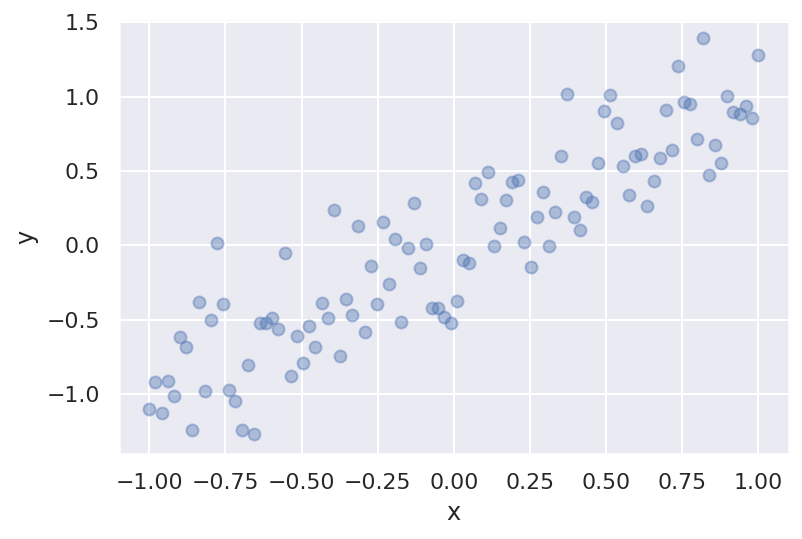

In [ ]:
# Create and plot 100 points of training data
x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]
print(f"train shape: {x_train.shape}")

plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Deterministic linear regression with MSE loss

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 4ms/step - loss: 0.0838
loss: 0.0838
Prediction: [[3.3028424e-05]]


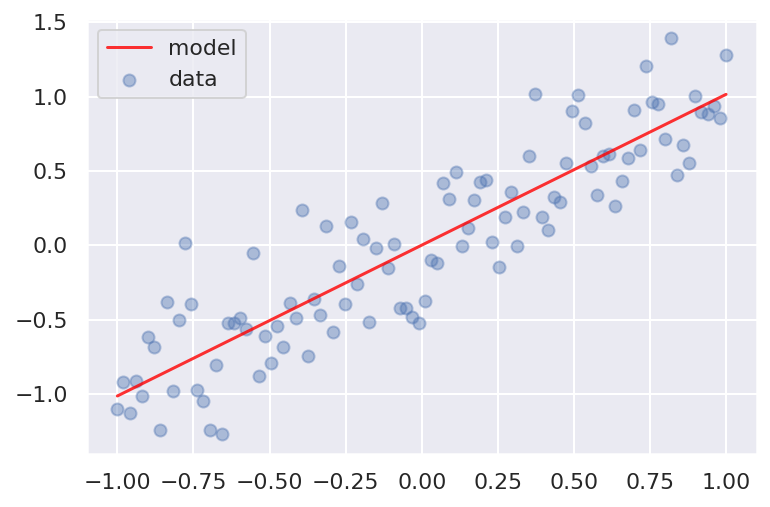

In [ ]:
# Create and train deterministic linear model 
# using mean squared error loss

# Create linear regression via Sequential model
model = Sequential([
    Dense(units=1, input_shape=(1,))
])

model.compile(loss=MeanSquaredError(), 
    optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)
print(f"loss: {model.evaluate(x_train, y_train):.4f}")

# Examine the model predictions
x = np.array([[0]])
y_model = model(x)
print(f"Prediction: {y_model}")

# Plot the data and model
plt.scatter(x_train, y_train, alpha=0.4, label='data')
plt.plot(x_train, model.predict(x_train), 
    color='red', alpha=0.8, label='model')
plt.legend()
plt.show()

#### Probabilistic linear regression with both user-defined and learned variance

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 1)                 2         
                                                                 
 distribution_lambda_22 (Dis  ((None, 1),              0         
 tributionLambda)             (None, 1))                         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 3ms/step - loss: 0.9765
loss: 0.9765
Distribution: tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1, 1], event_shape=[], dtype=float32)


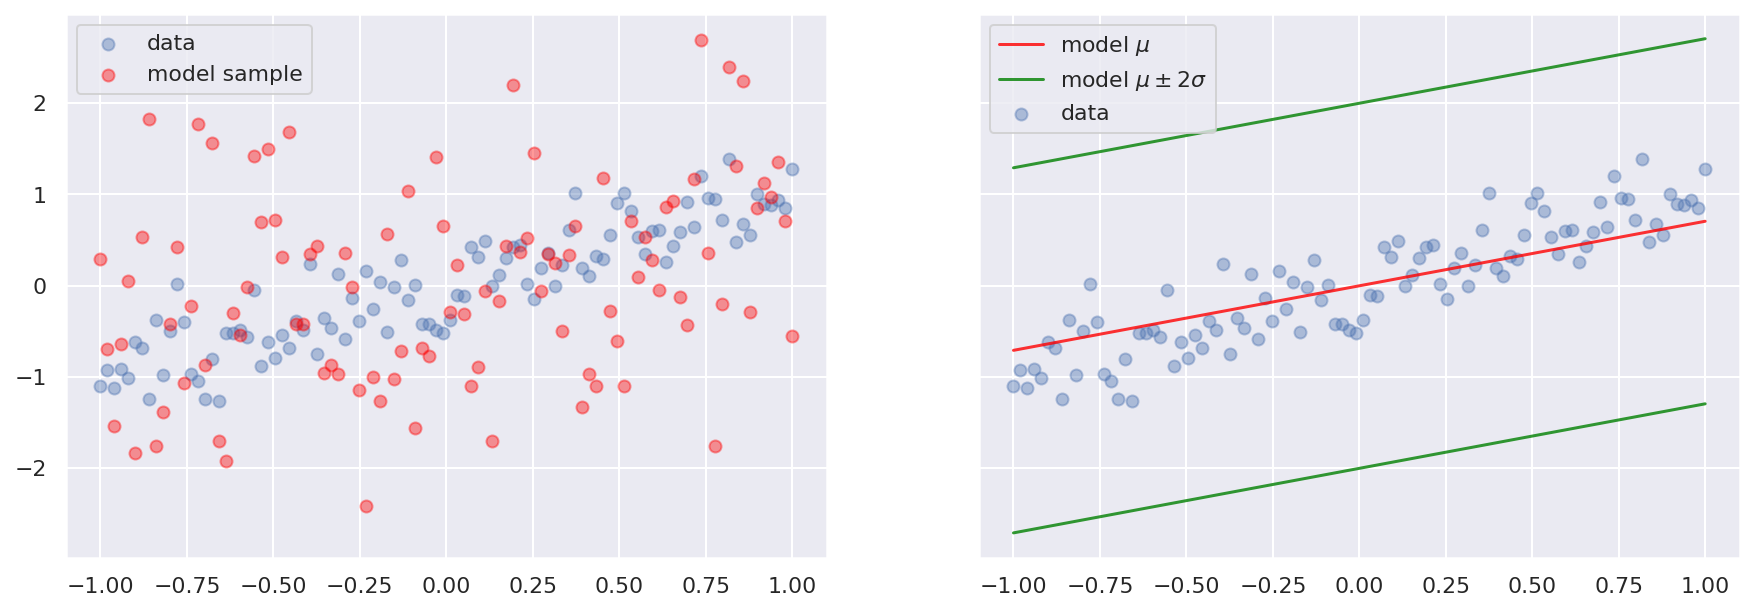

In [ ]:
# Create probabilistic regression with normal distribution as final layer
model = Sequential([
    Dense(units=1, input_shape=(1,)),
    tfpl.DistributionLambda(
        lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1.),
            reinterpreted_batch_ndims=-1))
])
model.summary()

# Train model using the negative loglikelihood
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(
    learning_rate=0.005))
model.fit(x_train, y_train, epochs=100, verbose=False)
print(f"loss: {model.evaluate(x_train, y_train):.4f}")

# Examine the distribution created as a feedforward value
x = np.array([[0]])
y_model = model(x)
print(f"Distribution: {y_model}")

# Plot the data and a sample from the model
y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, 
    color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, 
    label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, 
    label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 2)                 4         
                                                                 
 distribution_lambda_23 (Dis  ((None, 1),              0         
 tributionLambda)             (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 5ms/step - loss: 0.1766
loss: 0.1766
Distribution: tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1, 1], event_shape=[], dtype=float32)


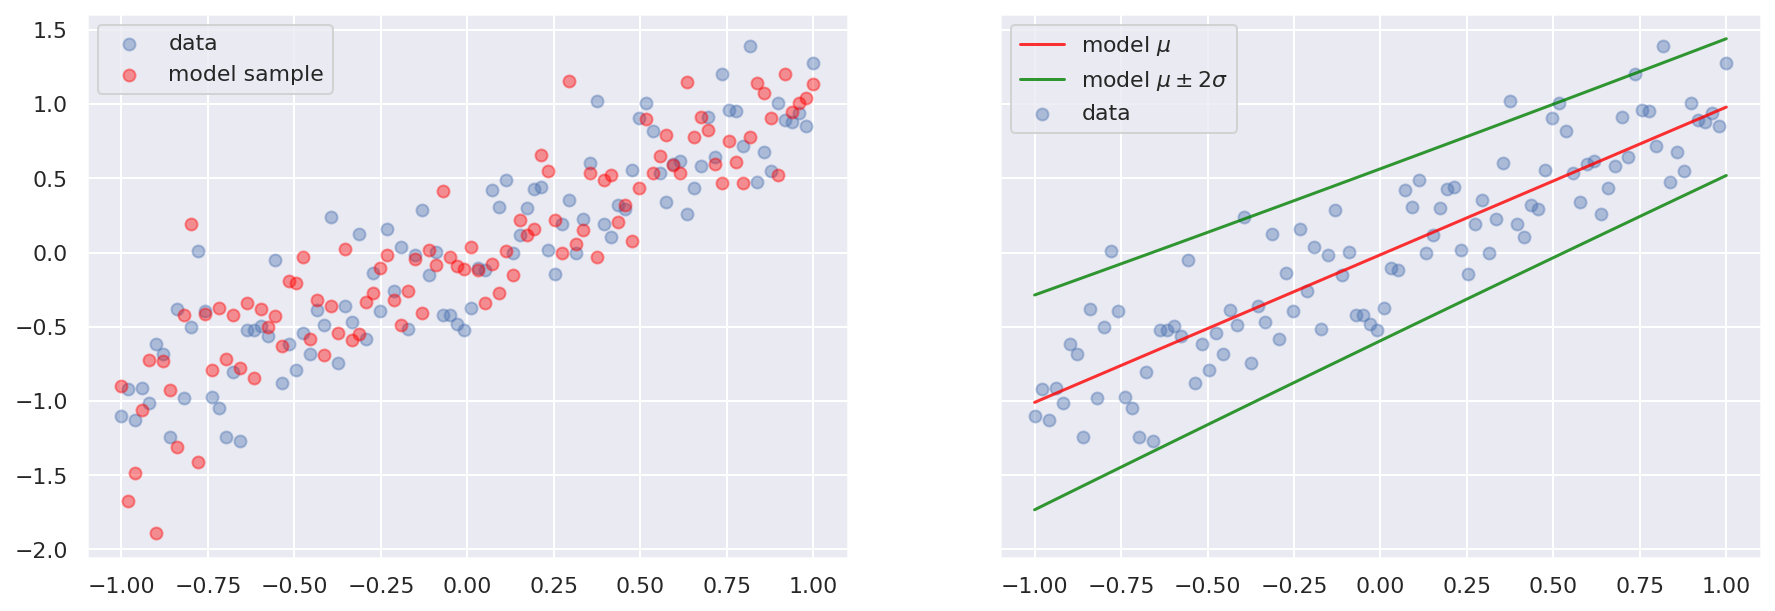

In [ ]:
# Create probabilistic regression with normal distribution as final layer
model = Sequential([
    Dense(units=2, input_shape=(1,)),
    tfpl.DistributionLambda(
        lambda t: tfd.Independent(tfd.Normal(
            loc=t[..., :1], scale=tf.math.softplus(t[..., 1:])),
            reinterpreted_batch_ndims=0))
])
model.summary()

# Train model using the negative loglikelihood
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(
    learning_rate=0.005))
model.fit(x_train, y_train, epochs=100, verbose=False)
print(f"loss: {model.evaluate(x_train, y_train):.4f}")

# Examine the distribution created as a feedforward value
x = np.array([[0]])
y_model = model(x)
print(f"Distribution: {y_model}")

# Plot the data and a sample from the model
y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, 
    color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, 
    label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, 
    label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 2)                 4         
                                                                 
 independent_normal_4 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 4ms/step - loss: 0.1726
loss: 0.1726
Distribution: tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1], event_shape=[1], dtype=float32)


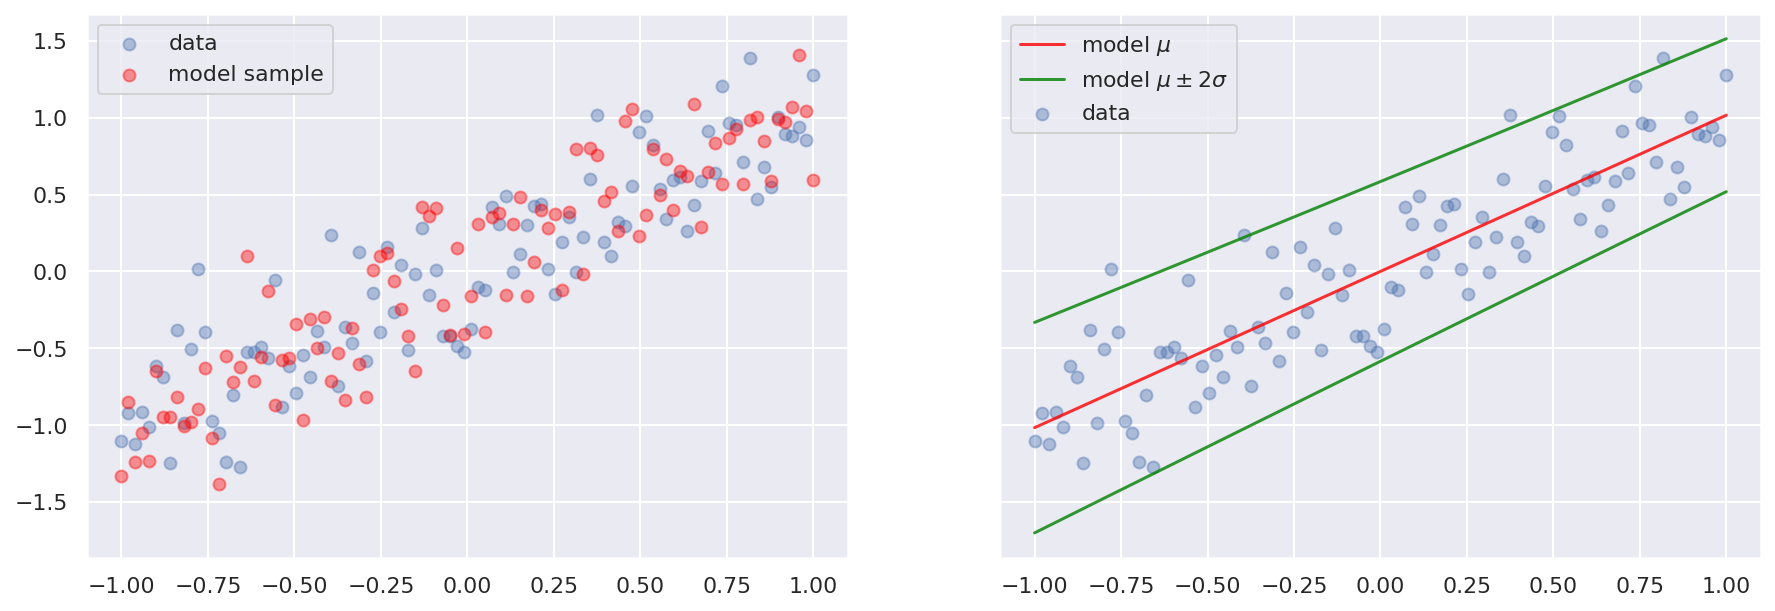

In [ ]:
# Create probabilistic regression with normal distribution as final layer
event_shape = 1
model = Sequential([
    Dense(units=tfpl.IndependentNormal.params_size(event_shape), 
        input_shape=(1,)),
    tfpl.IndependentNormal(event_shape)
])
model.summary()

# Train model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=200, verbose=False)
print(f"loss: {model.evaluate(x_train, y_train):.4f}")

# Examine the distribution created as a feedforward value
x = np.array([[0]])
y_model = model(x)
print(f"Distribution: {y_model}")

# Plot the data and a sample from the model
y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, 
    color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, 
    label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, 
    label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

#### Probabilistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

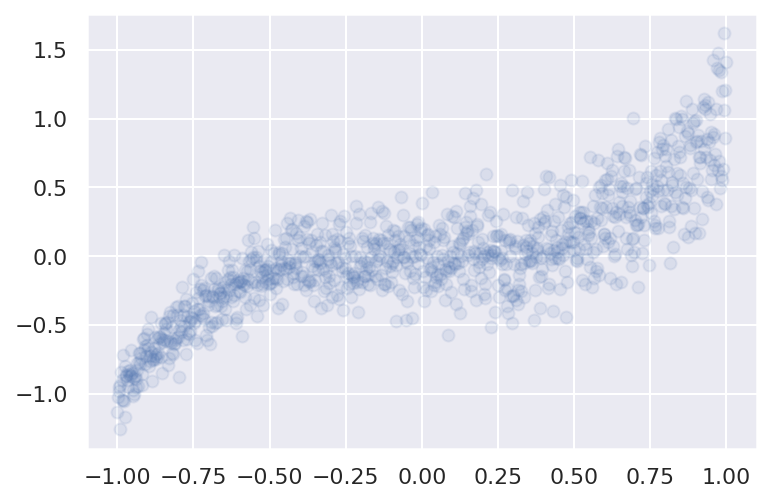

In [ ]:
# Create and plot 10000 data points
x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + \
    0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 8)                 16        
                                                                 
 dense_59 (Dense)            (None, 2)                 18        
                                                                 
 independent_normal_5 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________
32/32 [==============================] - 0s 1ms/step - loss: -0.0337
loss: -0.03368443623185158
Distribution: tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1], event_shape=[1], dtype=float32)


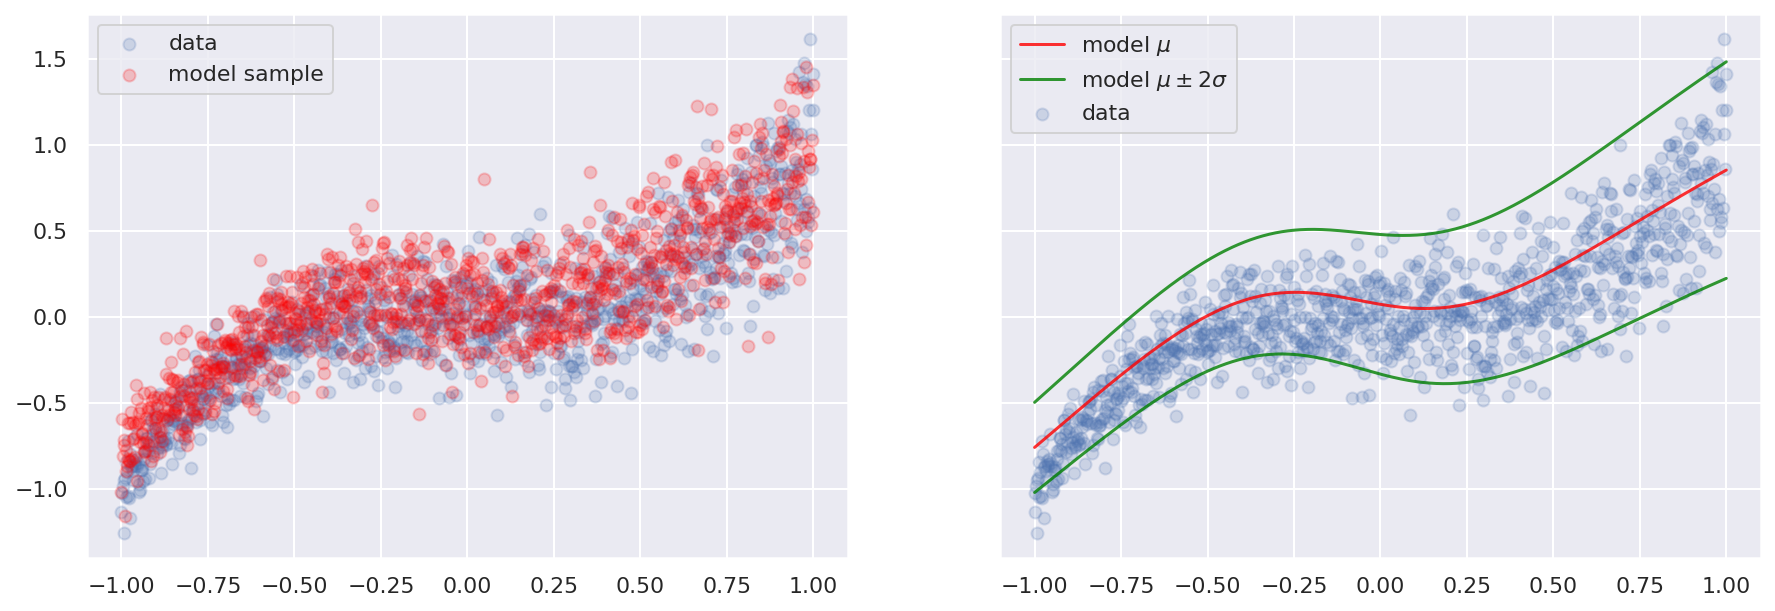

In [ ]:
# Create probabilistic regression: normal distribution with fixed variance
model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])

# Train model using the negative loglikelihood
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

# Train model
model.fit(x_train, y_train, epochs=200, verbose=False)
print(f"loss: {model.evaluate(x_train, y_train)}")

# Examine the distribution created as a feedforward value
x = np.array([[0]])
y_model = model(x)
print(f"Distribution: {y_model}")

# Plot the data and a sample from the model
y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='data')
ax1.scatter(x_train, y_sample, alpha=0.2, 
    color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, 
    label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, 
    label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

***
<a id="coding_tutorial_3"></a>
## The `DenseVariational` layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                                 
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________


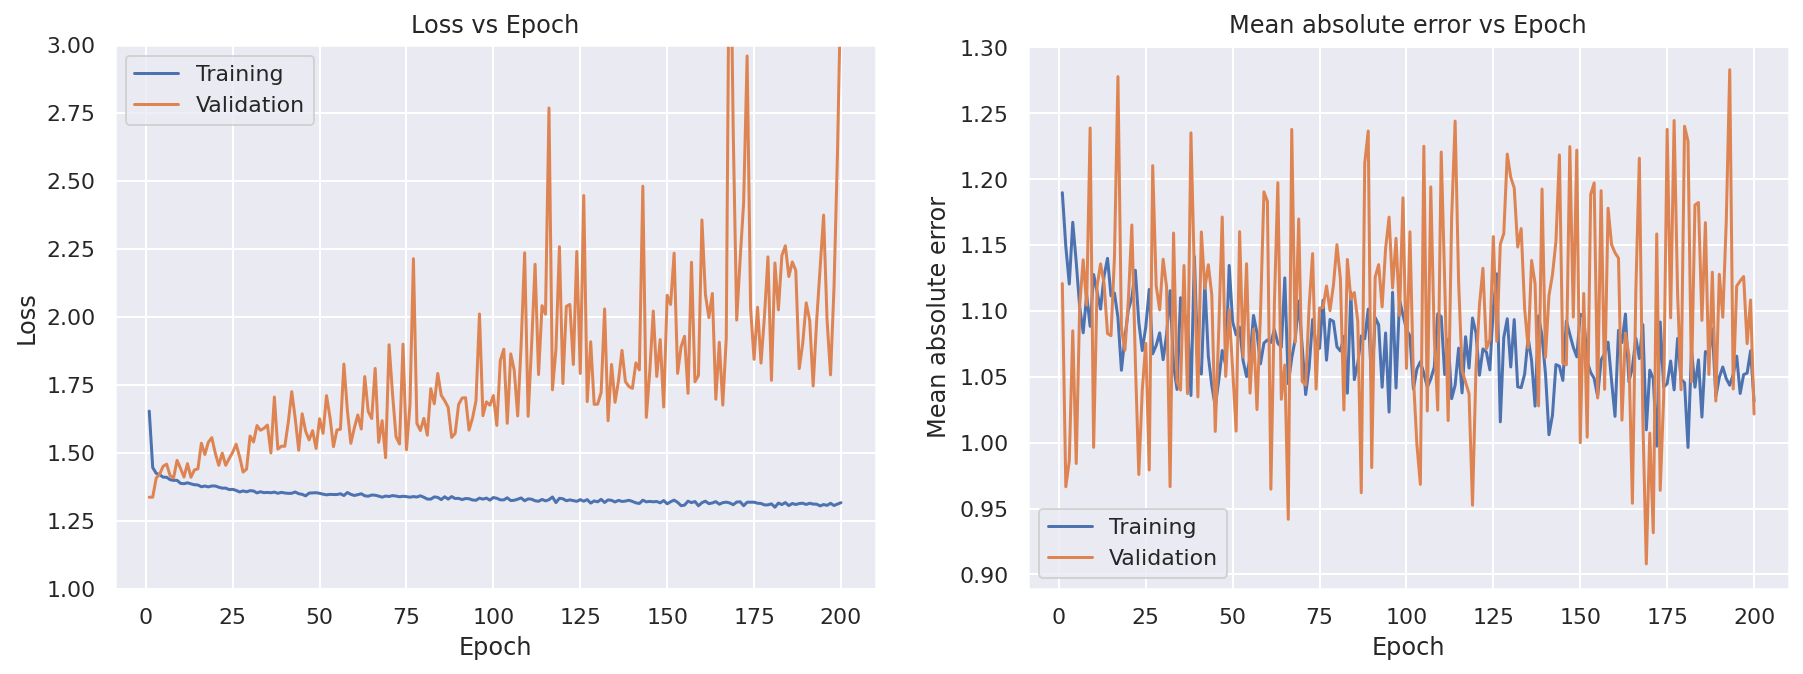

Test loss: 1.1389
Test mse: 0.1820


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanAbsoluteError
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(16, activation='relu', input_shape=(8,)),
    Dense(2),
    tfpl.IndependentNormal(1)])
model.summary()

model.compile(loss=lambda y_true, y_pred: 
    -y_pred.log_prob(y_true),
    optimizer=RMSprop(learning_rate=0.01),
    metrics=[MeanAbsoluteError()])

x_train = np.random.normal(size=(1000, 8))
y_train = np.random.normal(size=(1000,))
history = model.fit(x_train, y_train, validation_split=0.1, 
    epochs=200, batch_size=32, verbose=0)
# plot training history
plot_df = pd.DataFrame(history.history)
epoch = np.arange(1, len(plot_df)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Loss plot
ax1.plot(epoch, plot_df['loss'], label='Training')
ax1.plot(epoch, plot_df['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(1, 3)
ax1.set_title("Loss vs Epoch")
ax1.legend()
# Mean absolute error plot
ax2.plot(epoch, plot_df['mean_absolute_error'], label='Training')
ax2.plot(epoch, plot_df['val_mean_absolute_error'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean absolute error')
ax2.set_title("Mean absolute error vs Epoch")
ax2.legend()
plt.show()

x_test = np.random.normal(size=(1, 8))
y_test = np.random.normal(size=(1,))
test_loss, test_mse = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}\nTest mse: {test_mse:.4f}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVar  (None, 16)               288       
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 2)                68        
 ariational)                                                     
                                                                 
 independent_normal_1 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 356
Trainable params: 356
Non-trainable params: 0
_________________________________________________________________


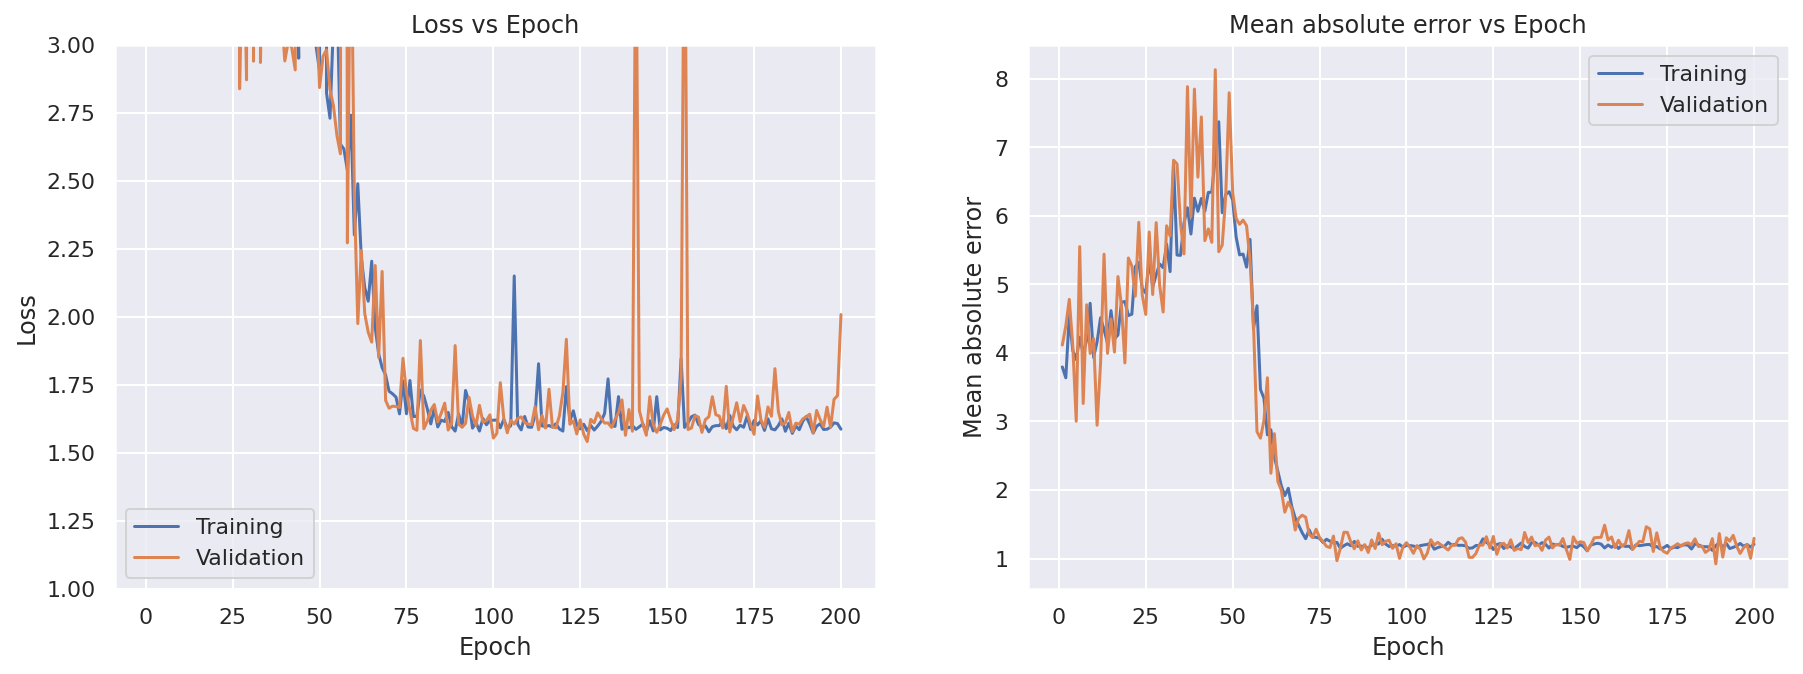

Test loss: 2.1090
Test mse: 0.5887


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanAbsoluteError
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfd.Independent(
        tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=1),
        reinterpreted_batch_ndims=1)
    
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), 
            dtype=dtype),
        tfpl.IndependentNormal(n, 
            convert_to_tensor_fn=tfd.Distribution.sample)])

# ELBO:
# q = q(w | theta)
# E_{w ~ q}[log p(D | w)] - KL[q || p]
#     = Sum_i E_{w ~ q}[log p(D_i | w)] - KL[q || p]

# For a minibatch:
# N/B * Sum_j E_{w ~ q}[log p(D_j | w)] - KL[q || p]

# Per example loss:
# 1/B * Sum_j E_{w ~q}[log p(D_j | w)] - 1/N * KL[q || p]

N=1000
model = Sequential([
    tfpl.DenseVariational(16, posterior, prior, 
        kl_weight=1/N, kl_use_exact=True,
        activation='relu', input_shape=(8,)),
    tfpl.DenseVariational(2, posterior, prior, 
        kl_weight=1/N, kl_use_exact=True),
    tfpl.IndependentNormal(1)])
model.summary()

model.compile(loss=lambda y_true, y_pred:
    -y_pred.log_prob(y_true),
    optimizer=RMSprop(learning_rate=0.01),
    metrics=[MeanAbsoluteError()])

x_train = np.random.normal(size=(N, 8))
y_train = np.random.normal(size=(N,))
history = model.fit(x_train, y_train, validation_split=0.1,
    epochs=200, batch_size=32, verbose=0)
# plot training history
plot_df = pd.DataFrame(history.history)
epoch = np.arange(1, len(plot_df)+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Loss plot
ax1.plot(epoch, plot_df['loss'], label='Training')
ax1.plot(epoch, plot_df['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(1, 3)
ax1.set_title("Loss vs Epoch")
ax1.legend()
# Mean absolute error plot
ax2.plot(epoch, plot_df['mean_absolute_error'], label='Training')
ax2.plot(epoch, plot_df['val_mean_absolute_error'], label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean absolute error')
ax2.set_title("Mean absolute error vs Epoch")
ax2.legend()
plt.show()

x_test = np.random.normal(size=(1, 8))
y_test = np.random.normal(size=(1,))
test_loss, test_mse = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}\nTest mse: {test_mse:.4f}")

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 8)]               0         
                                                                 
 DV01 (DenseVariational)     (None, 16)                576       
                                                                 
 DV02 (DenseVariational)     (None, 2)                 136       
                                                                 
 Output (IndependentNormal)  ((None, 1),               0         
                              (None, 1))                         
                                                                 
Total params: 712
Trainable params: 712
Non-trainable params: 0
_________________________________________________________________


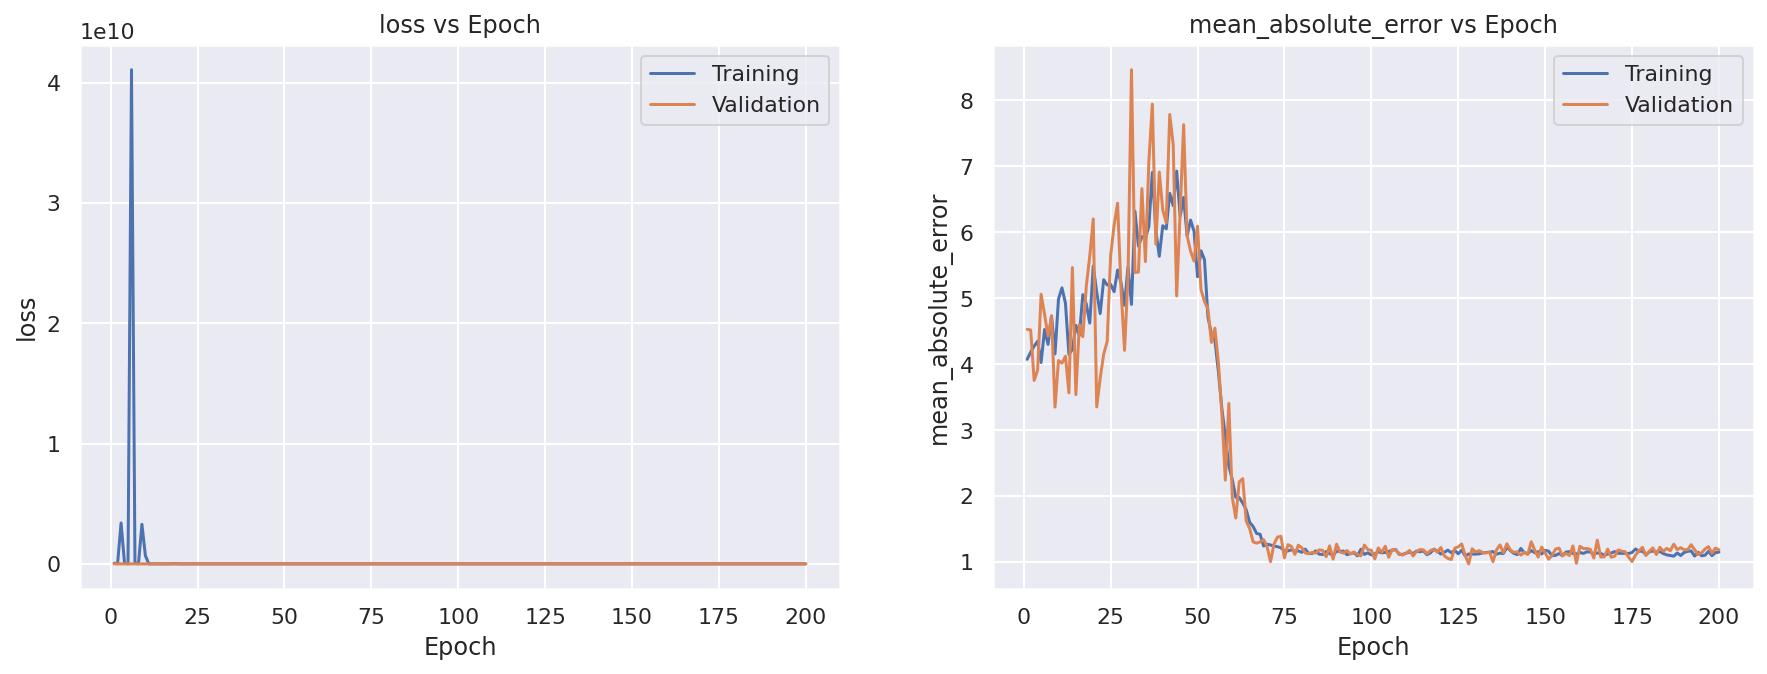

Test loss: 1.4884
Test mae: 0.8803


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanAbsoluteError
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(2*n, dtype=dtype),
        tfpl.DistributionLambda(lambda t:
            tfd.Independent(tfd.Normal(loc=t[..., :n], 
                scale=tf.math.softplus(t[..., n:])),
            reinterpreted_batch_ndims=1))])
    
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n),
            dtype=dtype),
        tfpl.IndependentNormal(n,
            convert_to_tensor_fn=tfd.Distribution.sample)])
    
N=1000
input = Input(shape=(8,), name='Input')
h = tfpl.DenseVariational(16, posterior, prior, kl_weight=1/N, 
    kl_use_exact=True, activation='relu', name='DV01')(input)
h = tfpl.DenseVariational(2, posterior, prior, kl_weight=1/N,
    kl_use_exact=True, name='DV02')(h)
output = tfpl.IndependentNormal(1, name='Output')(h)
model = Model(inputs=input, outputs=output)
# model = Sequential([
#     tfpl.DenseVariational(16, posterior, prior, 
#         kl_weight=1/N, kl_use_exact=True,
#         activation='relu', input_shape=(8,)),
#     tfpl.DenseVariational(2, posterior, prior,
#         kl_weight=1/N, kl_use_exact=True),
#     tfpl.IndependentNormal(1)
# ])
model.summary()

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
    optimizer=RMSprop(learning_rate=1e-2),
    metrics=[MeanAbsoluteError()])

train_x = np.random.normal(size=(N, 8))
train_y = np.random.normal(size=(N,))
history = model.fit(train_x, train_y, validation_split=0.1, 
    epochs=200, batch_size=32, verbose=0)

# Training history plot
figs = PlotMetrics(history=history, 
    metrics=['loss', 'mean_absolute_error'])
figs.plot()

test_x = np.random.normal(size=(100, 8))
test_y = np.random.normal(size=(100,))
test_loss, test_mse = model.evaluate(test_x, test_y, verbose=0)
print(f"Test loss: {test_loss:.4f}\nTest mae: {test_mae:.4f}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create linear data with Gaussian noise

The data you'll be working with is the same as you used before:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed. We'll be running a Bayesian linear regression on this data.

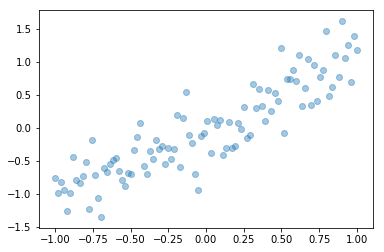

In [ ]:
# Use the same data as before -- create and plot 100 data points

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.show()

#### Create the prior and posterior distribution for model weights

In [ ]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([tfpl.DistributionLambda(
        lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n),
            scale_diag=tf.ones(n)))])
    return prior_model

In [ ]:
# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n),
            dtype=dtype),
        tfpl.MultivariateNormalTriL(n)])
    return posterior_model

#### Aside: analytical posterior

In this tutorial, we're using a variational posterior because, in most settings, it's not possible to derive an analytical one. However, in this simple setting, it is possible. Specifically, running a Bayesian linear regression on $x_i$ and $y_i$ with $i=1, \ldots, n$ and a unit Gaussian prior on both $\alpha$ and $\beta$:

$$
y_i = \alpha + \beta x_i + \epsilon_i, \quad 
\epsilon_i \sim N(0, \sigma^2), \quad 
\alpha \sim N(0, 1), \quad 
\beta \sim N(0, 1)
$$

gives a multivariate Gaussian posterior on $\alpha$ and $\beta$:

$$
\begin{pmatrix}
\alpha \\
\beta
\end{pmatrix}
\sim
N(\mathbf{\mu}, \mathbf{\Sigma})
$$
where
$$ 
\mathbf{\mu}
= 
\mathbf{\Sigma} 
\begin{pmatrix}
\hat{n} \bar{y} \\
\hat{n} \overline{xy}
\end{pmatrix},
\quad
\mathbf{\Sigma} = 
\frac{1}{(\hat{n} + 1)(\hat{n} \overline{x^2} + 1) - \hat{n}^2 \bar{x}^2}
\begin{pmatrix}
\hat{n} \overline{x^2} + 1 & -\hat{n} \bar{x} \\
-\hat{n} \bar{x} & \hat{n} + 1
\end{pmatrix}.
$$

In the above, $\hat{n} = \frac{n}{\sigma^2}$ and $\bar{t} = \frac{1}{n}\sum_{i=1}^n t_i$ for any $t$. In general, however, it's not possible to determine the analytical form for the posterior. For example, in models with a hidden layer with nonlinear activation function, the analytical posterior cannot be determined in general, and variational methods as below are useful.

#### Create the model with `DenseVariational` layers

In [ ]:
# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution

model = Sequential([
    tfpl.DenseVariational(input_shape=(1,), units=1,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0], kl_use_exact=True)])

model.compile(loss=MeanSquaredError(),
    optimizer=RMSprop(learning_rate=0.005))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_1 (DenseVa (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


#### Train model and inspect

In [ ]:
# Fit the model, just like a deterministic linear regression

model.fit(x_train, y_train, epochs=500, verbose=False)

In [ ]:
# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:           ', model_prior.mean().numpy())
print('prior variance:       ', model_prior.variance().numpy())
print('posterior mean:       ', model_posterior.mean().numpy())
print('posterior covariance: ', model_posterior.covariance().numpy()[0])
print('                      ', model_posterior.covariance().numpy()[1])

prior mean:            [0. 0.]
prior variance:        [1. 1.]
posterior mean:        [1.0331362  0.01086524]
posterior covariance:  [ 0.01758878 -0.00459222]
                       [-0.00459222  0.00681984]


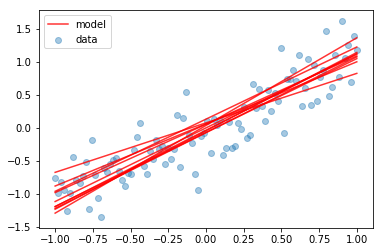

In [ ]:
# Plot an ensemble of linear regressions, with weights sampled from
# the posterior distribution

plt.scatter(x_train, y_train, alpha=0.4, label='data')
for _ in range(10):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)        
plt.legend()
plt.show()

#### Explore the effect of sample size

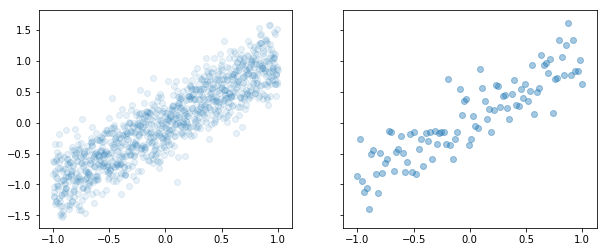

In [ ]:
# Create two datasets, one with 1000 points, another with 100

x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = x_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.scatter(x_train_1000, y_train_1000, alpha=0.1)
ax2.scatter(x_train_100, y_train_100, alpha=0.4)
plt.show()

In [ ]:
# Train a model on each dataset

model_1000 = Sequential([
    tfpl.DenseVariational(input_shape=(1,), units=1,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/1000)])

model_100 = Sequential([
    tfpl.DenseVariational(input_shape=(1,), units=1,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/100)])

model_1000.compile(loss=MeanSquaredError(), 
    optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(), 
    optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

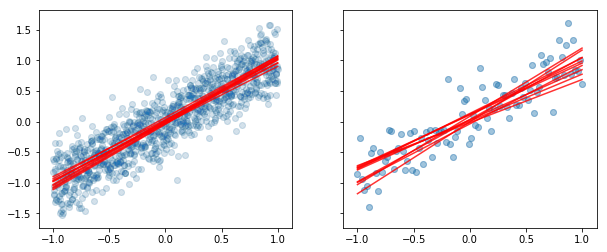

In [ ]:
# Plot an ensemble of linear regressions from each model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), 
    sharex=True, sharey=True)

for _ in range(10):
    y_model_1000 = model_1000(x_train_1000)
    ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
    ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)
    y_model_100 = model_100(x_train_100)
    ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05)
    ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)

plt.show()

#### Put it all together: nonlinear probabilistic regression with weight uncertainty

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

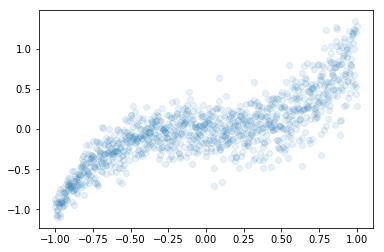

In [ ]:
# Create and plot 1000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [ ]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model = Sequential([
    tfpl.DenseVariational(units=8, input_shape=(1,),
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0], activation='sigmoid'),
    
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0]),
    
    tfpl.IndependentNormal(1)])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_8 (DenseVa (None, 8)                 152       
_________________________________________________________________
dense_variational_9 (DenseVa (None, 2)                 189       
_________________________________________________________________
independent_normal_2 (Indepe ((None, 1), (None, 1))    0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model

model.fit(x_train, y_train, epochs=1000, verbose=False)
model.evaluate(x_train, y_train)

1000/1000 [==============================] - 1s 983us/sample - loss: 0.0074


0.00743547534942627

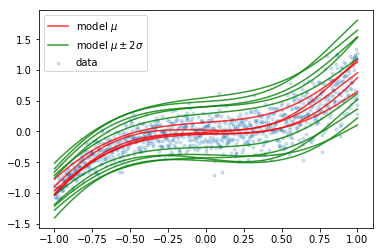

In [ ]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()
plt.show()

***
<a id="coding_tutorial_4"></a>
## Reparameterization layers

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, MaxPool2D
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    tfpl.Convolution2DReparameterization(16, [3, 3], 
        activation='relu', input_shape=(28, 28, 1),
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_prior_fn=tfpl.default_multivariate_normal_fn),
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(
        tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_1  (None, 26, 26, 16)        304       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_reparameterization_1 ( (None, 10)                20490     
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 10), (None, 10))  0         
Total params: 20,794
Trainable params: 20,794
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def custom_multivariate_normal_fn(dtype, shape, name, trainable, 
    add_variable_fn):
    normal = tfd.Normal(loc=tf.zeros(shape, dtype), 
        scale=2 * tf.ones(shape, dtype))
    batch_ndims = tf.size(normal.batch_shape_tensor())
    return tfd.Independent(normal, 
        reinterpreted_batch_ndims=batch_ndims)

model = Sequential([
    tfpl.Convolution2DReparameterization(16, [3, 3], 
        activation='relu', input_shape=(28, 28, 1),
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_prior_fn=custom_multivariate_normal_fn),
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(
        tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_2  (None, 26, 26, 16)        304       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_reparameterization_2 ( (None, 10)                20490     
_________________________________________________________________
one_hot_categorical_2 (OneHo ((None, 10), (None, 10))  0         
Total params: 20,794
Trainable params: 20,794
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dataset_size = 1000

model = Sequential([
    tfpl.Convolution2DReparameterization(16, [3, 3], 
        activation='relu', input_shape=(28, 28, 1),
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_posterior_tensor_fn=tfd.Distribution.sample,
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=True),
        bias_posterior_tensor_fn=tfd.Distribution.sample,
        bias_prior_fn=None,
        kernel_divergence_fn=(lambda q, p, _: tfd.kl_divergence(q, p) / dataset_size)),
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(
        tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_8  (None, 26, 26, 16)        304       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_reparameterization_8 ( (None, 10)                20490     
_________________________________________________________________
one_hot_categorical_8 (OneHo ((None, 10), (None, 10))  0         
Total params: 20,794
Trainable params: 20,794
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt

#### Load in the HAR dataset

You'll be working with the [Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. It consists of the readings from an accelerometer (which measures acceleration) carried by a human doing different activities. The six activities are walking horizontally, walking upstairs, walking downstairs, sitting, standing and laying down. The accelerometer is inside a smartphone, and, every 0.02 seconds (50 times per second), it takes six readings: linear and gyroscopic acceleration in the x, y and z directions. See [this link](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) for details and download. If you use it in your own research, please cite the following paper:

- Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013. 

The goal is to use the accelerometer data to predict the activity.

In [ ]:
# Load the HAR dataset and create some data processing functions

# Function to load the data from file
def load_HAR_data():
    data_dir = 'data/HAR/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

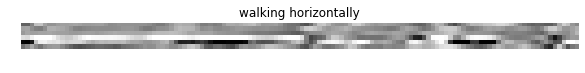

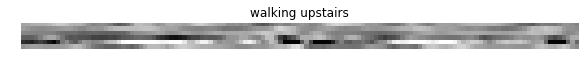

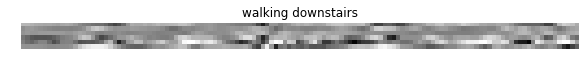

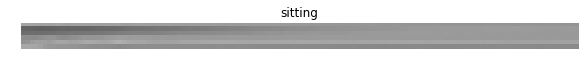

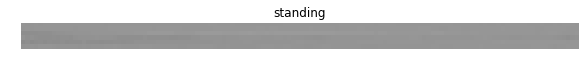

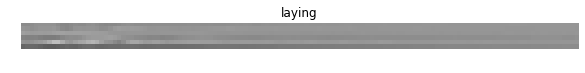

In [ ]:
# Inspect some of the data by making plots

def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()
        
make_plots(1)

#### 1D deterministic convolutional neural network

In [ ]:
# Create standard deterministic model with:
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense with Softmax

model = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


#### Probabilistic 1D convolutional neural network, with both weight and output uncertainty

In [ ]:
# Create probablistic model with the following layers:
#  - Conv1D
#  - MaxPooling
#  - Flatten
#  - Dense
#  - OneHotCategorical

divergence_fn = lambda q, p, _: tfd.kl_divergence(q, p) / x_train.shape[0]

model = Sequential([
    tfpl.Convolution1DReparameterization(input_shape=(128, 6),
        filters=8, kernel_size=16, activation='relu',
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn),
    MaxPooling1D(pool_size=16),
    Flatten(),
    tfpl.DenseReparameterization(
        units=tfpl.OneHotCategorical.params_size(6), activation=None,
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn),
    tfpl.OneHotCategorical(6)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_1  (None, 113, 8)            1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 8)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_reparameterization_1 ( (None, 6)                 684       
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 6), (None, 6))    0         
Total params: 2,236
Trainable params: 2,236
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Replace analytical Kullback-Leibler divergence with approximated one

def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [ ]:
# Compile the model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer=RMSprop(learning_rate=0.005),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [ ]:
# Train the model

model.fit(x_train, y_train_oh, epochs=20, verbose=False)
model.evaluate(x_train, y_train_oh)
model.evaluate(x_test, y_test_oh)

2947/2947 [==============================] - 1s 202us/sample - loss: 0.8495 - accuracy: 0.7251


[0.8494912760264598, 0.7251442]

#### Inspect model performance

In [ ]:
# Define function to analyse model predictions versus true labels

def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[image_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


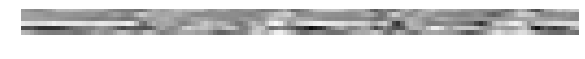

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


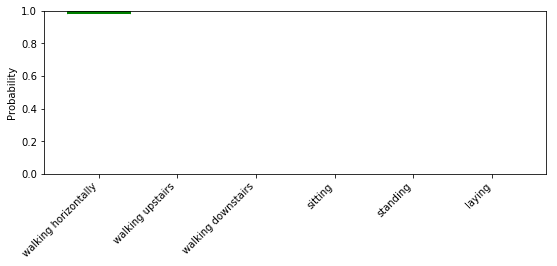

In [ ]:
analyse_model_predictions(image_num=79)

------------------------------
Accelerometer data:


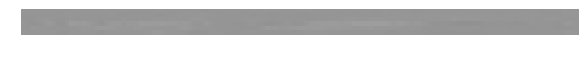

------------------------------
True activity: standing

------------------------------
Model estimated probabilities:


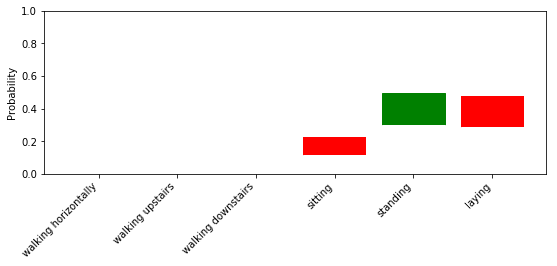

In [ ]:
analyse_model_predictions(image_num=633)

------------------------------
Accelerometer data:


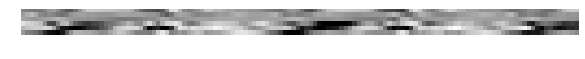

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


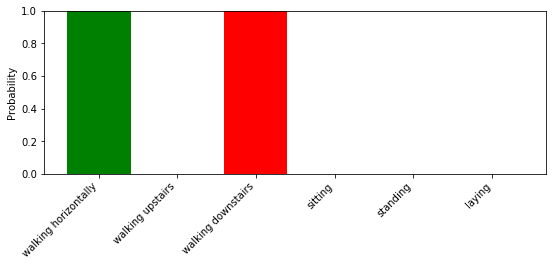

In [ ]:
analyse_model_predictions(image_num=1137)